<a href="https://colab.research.google.com/github/choi-yh/Pyhon_ML_Guide/blob/master/03%EC%9E%A5/03_00_%ED%8F%89%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 성능 평가 지표(Evaluation Metric)는 모델이 **분류**냐 **회귀**냐에 따라 나뉨
* **회귀**
    * 실제 값과 예측 값의 오차 평균값에 기반 (MSE, RMSLE, ...)
* **분류**
    * 정확도(Accuracy)
    * 오차행렬(Confusion Matrix)
    * 정밀도(Precision)
    * 재현율(Recall)
    * F1 Score
    * ROC AUC

## 01. 정확도(Accuracy)


* 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표  

$$\text{정확도(Accuracy)} = \frac{\text{예측 결과가 동일한 데이터 건수}}{\text{전체 예측 데이터 건수}}$$

* 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지는 않는다.

#### 정확도(Accuracy) 지표가 ML 성능을 왜곡하는 예시 - 타이타닉

* 여성이 생존 확률이 높았기 때문에 성별만을 가지고 성능을 확인

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Cabin'] = df['Cabin'].fillna('N')
    df['Embarked'] = df['Embarked'].fillna('N')
    df['Fare'] = df['Fare'].fillna(0)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df = df.drop(columns=['PassengerId', 'Name', 'Ticket'])
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [4]:
"""
사이킷런의 BaseEstimator 클래스를 상속받아 아무런 학습을 하지 않고,
성별에 따라 생존자를 예측하는 단순한 Classifier를 생성
Sex 피쳐가 1이면 0, 그렇지 않으면 1로 예측
"""

from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 에측함
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1

        return pred

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할
df = pd.read_csv("/gdrive/My Drive/Python/파이썬_머신러닝_완벽_가이드/data/titanic_train.csv")
y = df['Survived']
X = df.drop('Survived', axis=1)
X = transform_features(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.8212


* 단순하게 성별만 가지고 판별해도 82%의 정확도가 나온다.
* 불균형한(imbalanced)한 레이블값 분포에서 ML 모델의 성능을 판단할 경우, 정확도(Accuracy)는 적합한 평가 기준이 아니다.

#### MNIST 데이터 셋을 통해 불균형한 레이블에서 정확도가 어떻게 작용하는지 확인

* MNIST 데이터셋을 multi classification에서 binary classification으로 변경

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass

    # 입력 값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=13)

In [7]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기: ', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는: {:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기:  (450,)
테스트 세트 레이블 0과 1의 분포도
0    414
1     36
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.920


불균형할 경우 치우친 쪽으로 예측해버리면 정확도 자체는 올라간다.

## 02. 오차 행렬(Confusion Matrix)

 이진 분류의 예측 오류가 얼마인지와, 어떠한 유형의 예측 오류가 발생하고 있는지를 나타내는 지표

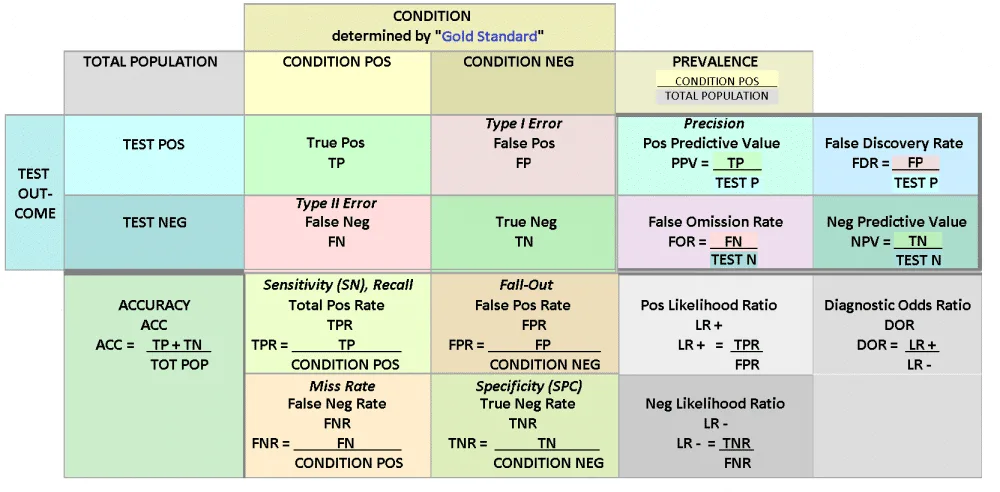

* 앞 문자 True/False는 **예측값과 실제값이 '같은가/틀린가'**
* 뒤 문자 Negative/Positive는 **예측 결과 값이 부정(0)/긍정(1)**
    * **TN**: 예측은 Negative, 실제로도 0(Negative)
    * **FP**: 예측은 Positive, 실제는 0(Negative)
    * **FN**: 예측은 Negative, 실제는 1(Positive)
    * **TP**: 예측은 Positive, 실제로도 1(Positive)

In [8]:
"""
정확도 예제에서 다른 MyFakeClassifier의 예측 성능 지표를 오차 행렬로 표현
ndarray 형태로 리턴됨
"""

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)

array([[414,   0],
       [ 36,   0]])

* 7이 아닌것을 7이 아닌 것으로 예측한 것이 414건(TN)
* 7인것을 7이 아니라고 예측한 것이 36건(FN)

* 정확도(Accuracy)는 예측 값과 실제 값이 얼마나 동일한가에 대한 비율로 결정  
즉, 오차행렬에서 True에 해당하는 값인 TN과 TP에 좌우됨

$$\text{정확도} = \frac{ \text 예측 결과와 실제 값이 동일한 건수 }{ \text 전체 데이터 수} = \frac{TN + TP}{TN + FP + FN + TP}$$


* 불균형한 레이블 클래스를 가지는 데이터 세트에서 중점적으로 찾아야 하는 적은 수의 결과 값에 Positive를 설정해 1값을 부여한다.
    * 사기 행위 예측 - 사기 행위가 1
    * 암 검진 모델 - 양성이 1

* ML 모델에서 알고리즘이 Positive보다는 Negative로 예측 정확도가 높아지는 경향이 생긴다. => TN은 매우 커지고, TP는 매우 작아지게 된다.
* Negative로 예측할 때 정확도가 높기 때문에 **FN(Negative로 예측할 때 틀린 데이터 수)**이 매우 작고,  
Positive로 예측하는 경우가 작기 때문에 FP 역시 매우 작아진다.

## 03. 정밀도와 재현율(Precision & Recall)



* 정밀도와 재현율은 **Positive 데이터 세트**의 예측 성능에 좀 더 초점을 맞춘 평가 지표  
$$ \text{정밀도(Precision)} = \frac{TP}{FP + TP} $$,  $$ \text{재현율(Recall)} = \frac{TP}{FN + TP} $$

* **정밀도(Precision)**
    * **예측을 Positive로 한 대상 중**, 예측과 실제 값이 Positive로 일치한 데이터의 비율
    * 분모(FP + TP): 예측을 Positive로 한 모든 데이터 건수
    * 분자(TP): 예측과 실제 값이 Positive로 일치한 데이터 건수
    * Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 **양성 예측도** 라고도 한다.

* **재현율(Recall)**
    * **실제 값이 Positive인 대상 중**, 예측과 실제 값이 Positive로 일치한 데이터의 비율
    * 분모(FN + TP): 실제 값이 Positive인 모든 데이터 건수
    * 분자(TP): 예측과 실제 값이 Positive로 일치한 데이터 건수
    * **민감도(Sensitivity)** 또는 **TPR(True Positive Rate)** 라고도 한다.

* **재현율**이 중요 지표인 경우
    * 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
    * ex) 암 판단 모델, 금융 사기 적발 모델

* **정밀도**가 더 중요한 지표인 경우
    * 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
    * 스팸메일 여부를 판단하는 모델

* 재현율과 정밀도 모두 TP를 높이는 데 동일하게 초점을 맞추지만, 재현율은 **FN(실제 Positive, 예측 Negative)를 낮추는 데**, 정밀도는 **FP를 낮추는 데** 초점을 맞춘다.  
=> 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는데 사용

In [9]:
# 평가를 간단하게

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)

    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율:{recall:.4f}')

In [10]:
# 로지스틱 회귀를 기반으로 타이타닉 생존자 예측

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
df = pd.read_csv("/gdrive/My Drive/Python/파이썬_머신러닝_완벽_가이드/data/titanic_train.csv")
y = df['Survived']
X = df.drop('Survived', axis=1)
X = transform_features(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

lr = LogisticRegression()

lr.fit(X_train, y_train)
pred = lr.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[93 17]
 [16 53]]
정확도: 0.8156, 정밀도: 0.7571, 재현율:0.7681


### 정밀도 / 재현율 트레이드 오프

* 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다.
* **정밀도/재현율의 트레이드 오프(Trade-off)**: 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지는 현상
* 일반적으로 이진 분류에서는 임곗값을 0.5, 즉 50%로 정하고 이 기준 값보다 확률이 크면 Positive, 작으면 Negative로 결정

In [11]:
# predict_proba 메서드를 통해 확인

pred_proba = lr.predict_proba(X_test)
pred = lr.predict(X_test)
print(f'pred_proba() 결과 Shape: {pred_proba.shape}')
print('pred_proba array에서 앞 3개만 샘플로 추출: \n', pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출: 
 [[0.62686829 0.37313171]
 [0.83997507 0.16002493]
 [0.91374683 0.08625317]]
두 개의 class중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.62686829 0.37313171 0.        ]
 [0.83997507 0.16002493 0.        ]
 [0.91374683 0.08625317 0.        ]]


In [12]:
"""Binarizer를 활용한 threshold 이해"""

from sklearn.preprocessing import Binarizer

X = [
     [1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]
     ]

# X의 개별 원소들이 threshold 값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [13]:
"""predict 메서드는 predict_proba를 Binarizer한 결과 값과 같다"""

from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 컬럼, 즉 Positive 클래스 컬럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[93 17]
 [16 53]]
정확도: 0.8156, 정밀도: 0.7571, 재현율:0.7681


In [14]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임계값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[89 21]
 [11 58]]
정확도: 0.8212, 정밀도: 0.7342, 재현율:0.8406


임계값을 낮추니 정밀도는 감소, 재현율을 상승  
왜? 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이다.  
임계를 낮췄기 때문에 Positive로 예측할 확률이 증가한다. => FP, TP가 증가한다. -> FN은 감소하고, 정밀도는 감소, 재현율은 증가

In [15]:
"""임계값을 0.4에서부터 0.6까지 0.05씩 증가하며 평가 지표 조사"""

# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration 하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임계값: ", custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값:  0.4
오차 행렬
[[89 21]
 [11 58]]
정확도: 0.8212, 정밀도: 0.7342, 재현율:0.8406
임계값:  0.45
오차 행렬
[[90 20]
 [12 57]]
정확도: 0.8212, 정밀도: 0.7403, 재현율:0.8261
임계값:  0.5
오차 행렬
[[93 17]
 [16 53]]
정확도: 0.8156, 정밀도: 0.7571, 재현율:0.7681
임계값:  0.55
오차 행렬
[[99 11]
 [18 51]]
정확도: 0.8380, 정밀도: 0.8226, 재현율:0.7391
임계값:  0.6
오차 행렬
[[100  10]
 [ 19  50]]
정확도: 0.8380, 정밀도: 0.8333, 재현율:0.7246


|평가 지표| 0.4 | 0.45 | 0.5 | 0.55 | 0.6 |
|:-------:|:---:|:----:|:---:|:----:|:---:|
| 정확도 |0.8212|0.8212|0.8156|0.8380|0.8380|
| 정밀도 |0.7342|0.7403|0.7571|0.8226|0.8333|
| 재현율 |0.8406|0.8261|0.7681|0.7391|0.7246|


In [16]:
# precision_recall_curve(): 임계값 변화에 따른 평가 지표

from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을추출
pred_proba_class1 = lr.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape: ', thresholds.shape)

# 반환된 임계값 배열 row가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 Shape:  (160,)
샘플 추출을 위한 임계값 배열의 index 10개:  [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임계값:  [0.07 0.09 0.11 0.13 0.15 0.34 0.49 0.63 0.73 0.86 0.94]
샘플 임계값별 정밀도:  [0.408 0.442 0.489 0.538 0.614 0.698 0.761 0.839 0.925 0.92  0.8  ]
샘플 임계값별 재현율:  [1.    0.986 0.957 0.928 0.899 0.87  0.783 0.681 0.536 0.333 0.116]


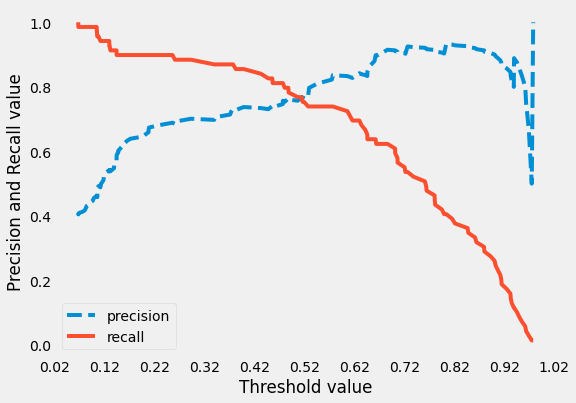

In [17]:
# 시각화

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('fivethirtyeight')

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0: threshold_boundary], label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # X축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr.predict_proba(X_test)[:, 1])

임계값이 낮을수록 양성 예측을 많이 하기 때문에 정밀도는 낮아지고 재현율은 극도로 올라간다.  
임계값이 0.5 정도일 때 정밀도와 재현율이 비슷해졌다.

### 정밀도와 재현율의 맹점

* 임계값은 업무 환경에 맞게 정밀도와 재현율을 상호 보완할 수 있는 수준에서 적용되어야 한다.
---

#### 정밀도가 100%가 되는 방법

* 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측한다.
* Positive 예측을 확실한 경우만 하기 때문에 FP가 0이 된다.
---

#### 재현율이 100%가 되는 방법

* 모든 환자를 Positive로 예측한다.
* Negative로 예측해서 틀리지 않기 때문에 FN이 0이 되고 Recall은 100이 된다.
---

* 어느 한쪽만 참조하면 극단적인 수치 조작이 가능해진다.
* 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주할 수 있다.

## 04. F1 Score

* F1 Score는 정밀도와 재현율을 결합한 지표
* 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 높은 값이 나온다.
*
$$ F1 = \frac{2}{ \frac{1}{recall} + \frac{1}{precision} } = 2 * \frac{precision * recall}{precision + recall}$$

In [18]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print(f'F1 스코어: {f1:.4f}')

F1 스코어: 0.7626


In [19]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)

    # F1 스코어 추가
    f1 = f1_score(y_test, pred)

    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}')


thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값:  0.4
오차 행렬
[[89 21]
 [11 58]]
정확도: 0.8212, 정밀도: 0.7342, 재현율: 0.8406, F1: 0.7838
임계값:  0.45
오차 행렬
[[90 20]
 [12 57]]
정확도: 0.8212, 정밀도: 0.7403, 재현율: 0.8261, F1: 0.7808
임계값:  0.5
오차 행렬
[[93 17]
 [16 53]]
정확도: 0.8156, 정밀도: 0.7571, 재현율: 0.7681, F1: 0.7626
임계값:  0.55
오차 행렬
[[99 11]
 [18 51]]
정확도: 0.8380, 정밀도: 0.8226, 재현율: 0.7391, F1: 0.7786
임계값:  0.6
오차 행렬
[[100  10]
 [ 19  50]]
정확도: 0.8380, 정밀도: 0.8333, 재현율: 0.7246, F1: 0.7752


임계값이 0.4일 때 f1이 가장 좋음

## 05. ROC 곡선과 AUC

* 이진 분류의 예측 성능 측정에서 중요하게 사용되ㅏ는 지표
* ROC(Receiver Operation Characteristic Curve. 수신자 판단 곡선) - 2차 대전 때 통신 장비 성능 평가를 위해 고안된 수치이다.
* ROC Curve는 **FPR(False Positive Rate)가 변화할 때, TPR(True Positive Rate)가 어떻게 변화하는지 나타내는 곡선**


* TPR (True Positive Rate) 
    * 재현율 (Recall), 민감도 (Sensitivity)
    * $$TPR = \frac{TP}{FN + TP}$$
    * 실제 값 Positive(양성)이 정확히 예측돼야 하는 수준 (질병이 있는 사람을 질병이 있다고 판단)

* TNR (True Negative Rate)
    * 특이성 (Specificity)
    * $$TNR = \frac{TN}{FP + TN}$$
    * 실제 값 Negative(음성)이 정확히 예측돼야 하는 수준 (질병이 없는 사람을 건강하다고 판단)

* FPR (False Positive Rate)
    * $$FPR = \frac{FP}{FP + TN} = 1 - TNR = 1 - 특이성$$


* ROC Curve는 FPR 을 0부터 1까지 변화하면서 TPR의 변화값을 계산
* FPR을 변경하는 방법은 분류 결정 임계값을 조절하는 것이다.
* 분류 결정 임계값은 Positive 예측값을 결정하는 확률이므로 **FPR을 0으로 만드려면 임계값을 1로 지정**하면 된다. (임계값이 높아져 틀린 Positive를 내지 않음)
* **FPR을 1로 만들기 위해서는 TN을 0으로 만든다 -> 임계값을 0으로 지정**한다. (모든 예측을 Positive로 하기 때문에 TN이 0이다.)


* ROC Curve 자체는 FPR과 TPR의 변화 값을 보는 데 이용, 분류의 성능 지표로 사용되ㅏ는 것은 ROC 곡선 면적에 기반한 **AUC** 값으로 결정
* **AUC (Area Under Curve)** 값은 ROC Curve 밑의 면적을 구한 것으로 일반적으로 1에 가까울수록 좋은 수치이다.
* AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건

In [23]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열에서 샘플로 데이터를 추출하되, 임계값을 5 Step으로 추출
# thresholds[0]은 max(예측확률) + 1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index: ', thr_index)
print('샘플 index로 추출한 임계값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: \n', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: \n', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index:  [ 1  6 11 16 21 26 31 36 41 46 51 56 61]
샘플 index로 추출한 임계값:  [0.98 0.8  0.66 0.58 0.51 0.46 0.34 0.15 0.14 0.12 0.11 0.1  0.06]
샘플 임계값별 FPR: 
 [0.    0.027 0.045 0.091 0.155 0.182 0.236 0.373 0.473 0.518 0.664 0.718
 0.918]
샘플 임계값별 TPR: 
 [0.014 0.406 0.638 0.739 0.768 0.826 0.87  0.899 0.913 0.942 0.957 0.986
 1.   ]


임계값이 1에 가까운 값에서 점점 작아지면서 FPR이 점차 커진다.  
FPR이 조금씩 커질 때 TPR은 가파르게 증가한다.

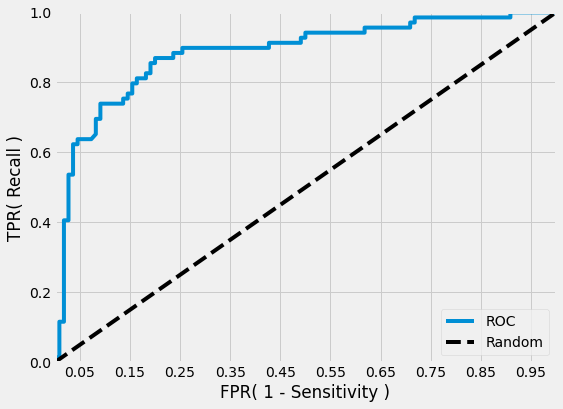

In [28]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임계값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)

    plt.figure(figsize=(8, 6))
    # ROC Curve를 그래프로 그림
    plt.plot(fprs, tprs, label='ROC')

    # 가운데 대각선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y 축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

roc_curve_plot(y_test, pred_proba[:, 1])

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_test, pred))
print("정확도: ", np.round(accuracy_score(y_test, pred), 4))
print("정밀도: ", np.round(precision_score(y_test, pred), 4))
print("재현율: ", np.round(recall_score(y_test, pred), 4))

[[93 17]
 [16 53]]
정확도:  0.8156
정밀도:  0.7571
재현율:  0.7681


In [34]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')